# 🔍 Project Overview

This notebook analyzes the LIAR2 dataset using Named Entity Recognition (NER) models to compare differences between true and false statements. 

## **📌 Workflow**
1️⃣ **Installing requirements** – Install neccessary libraries with correct versions  
2️⃣ **Importing libraries** – import all libraries    
3️⃣ **Loading training data** – loading csv dataset     
4️⃣ **Separating columns** – Using only statement, label columns. Others are not important in this part   
5️⃣ **Adding binary column (fake or real)** – Since there are 6 categories for fake/true statement, we need to map it into 1/0    
6️⃣ **NEW MODELS** – Currently A: RoBERTa, B: dbmdz BERT  
7️⃣ **Splitting df into true and false** – To easier extracting and counting entities in fake vs real, we split df into fake and real frames.      
8️⃣ **Counting entities from true/false of each NER model** – Counting entities in fake and real df   
9️⃣ **Dsiplaying top 5 entities based on count** – Show top 5 from each as a df   
🔟 **Visualizations** – Create graphs showing entity distributions.     


In [251]:
# 1: Installing requirements
%pip install -r requirements_part1.txt > --quiet

Note: you may need to restart the kernel to use updated packages.


In [252]:
# 2: Importing libraries
import pandas as pd
from transformers import pipeline
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 3: Loading training data
df_all_features = pd.read_csv("../liar2/train.csv")

df_all_features.head(2)

,id,label,statement,date,subject,speaker,speaker_description,state_info,true_counts,mostly_true_counts,half_true_counts,mostly_false_counts,false_counts,pants_on_fire_counts,context,justification
0,13847,5,"90 percent of Americans ""support universal bac...","October 2, 2017",government regulation;polls and public opinion...,chris abele,"Chris Abele is Milwaukee County Executive, a p...",wisconsin,1,4,5,3,5,2,a tweet,"""Universal"" is the term for background checks ..."
1,13411,1,Last year was one of the deadliest years ever ...,"May 19, 2017",after the fact;congress;criminal justice;histo...,thom tillis,Thom Tillis is a Republican who serves as U.S....,north carolina,0,2,7,3,2,0,a press release supporting the Back The Blue A...,"Sen. Thom Tillis, a North Carolina Republican,..."


In [254]:
# 4: Seprating columns 
df = df_all_features[["statement", "label"]]

df.head(2)

,statement,label
0,"90 percent of Americans ""support universal bac...",5
1,Last year was one of the deadliest years ever ...,1


In [255]:
# 5: Adding binary column (true/false)

true_labels = [5, 4, 3]
false_labels = [0, 1, 2]

def convert_label(label):
    if label in true_labels:  
        return 1
    elif label in false_labels:
        return 0
    else:
        return 'Out-Of-Range'

df = df.copy()
df.loc[:, "label_binary"] = df["label"].apply(convert_label)

df.head(2)


,statement,label,label_binary
0,"90 percent of Americans ""support universal bac...",5,1
1,Last year was one of the deadliest years ever ...,1,0


## 6: NER models

### A: Jean-Baptiste/roberta-large-ner-english (RoBERTa-Large)
- PER (Person names)
- ORG (Organizations)
- LOC (Locations)
- MISC (Other special entities)   
              
✅ Tokenization Type: Byte-Pair Encoding (BPE)      
- RoBERTa uses Byte-Pair Encoding (BPE) for tokenization.
- Instead, it uses “Ġ” before words to indicate a space.
    

In [256]:
# Load Jean-Baptiste RoBERTa
ner_pipeline_A = pipeline("ner", model="Jean-Baptiste/roberta-large-ner-english")


Device set to use mps:0


In [257]:
# NER tagging, cleaning, extracting
def clean_entities_A(entities):
    """Extracts entity type and cleaned word, removing 'Ġ' artifacts."""
    return [(ent["word"].replace("Ġ", ""), ent["entity"]) for ent in entities]


df = df.copy()  

df["A_raw_entities"] = df["statement"].apply(ner_pipeline_A)
df["A_entities"] = df["A_raw_entities"].apply(clean_entities_A)


df.head(3)

,statement,label,label_binary,A_raw_entities,A_entities
0,"90 percent of Americans ""support universal bac...",5,1,"[{'entity': 'MISC', 'score': 0.99866974, 'inde...","[(Americans, MISC)]"
1,Last year was one of the deadliest years ever ...,1,0,[],[]
2,"Bernie Sanders's plan is ""to raise your taxes ...",0,0,"[{'entity': 'PER', 'score': 0.9983652, 'index'...","[(Bernie, PER), (Sanders, PER)]"


### B: dbmdz/bert-large-cased-finetuned-conll03-english (BERT-Large)
- PER (Person names)
- LOC (Locations)
- MISC (Other special entities)

✅ Tokenization Type: WordPiece		
- WordPiece Tokenization splits words into smaller subwords.
- It does not use “Ġ” like RoBERTa.
- Instead, subword parts start with `##` to indicate they belong to the previous word.


In [258]:
# Load dbmdz BERT
ner_pipeline_B = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


In [259]:
# NER tagging, merging, extracting
def merge_entities_B(entities):
    """Merges WordPiece tokens correctly while keeping distinct words separate."""
    merged = []
    current_word = ""
    current_entity = None

    for ent in entities:
        word = ent["word"]
        entity = ent["entity"]

        if word.startswith("##"):  # It's a subword, merge it
            current_word += word[2:]  # Remove "##" and append
        else:  # New word starts
            if current_word:  # Store previous word
                merged.append((current_word, current_entity))
            current_word = word  # Start new word
            current_entity = entity

    # Add last merged entity
    if current_word:
        merged.append((current_word, current_entity))

    return merged



df = df.copy()  

df["B_raw_entities"] = df["statement"].apply(ner_pipeline_B)
df["B_entities"] = df["B_raw_entities"].apply(merge_entities_B)


df.head(3)

,statement,label,label_binary,A_raw_entities,A_entities,B_raw_entities,B_entities
0,"90 percent of Americans ""support universal bac...",5,1,"[{'entity': 'MISC', 'score': 0.99866974, 'inde...","[(Americans, MISC)]","[{'entity': 'I-MISC', 'score': 0.99725264, 'in...","[(Americans, I-MISC)]"
1,Last year was one of the deadliest years ever ...,1,0,[],[],[],[]
2,"Bernie Sanders's plan is ""to raise your taxes ...",0,0,"[{'entity': 'PER', 'score': 0.9983652, 'index'...","[(Bernie, PER), (Sanders, PER)]","[{'entity': 'I-PER', 'score': 0.9991854, 'inde...","[(Bernie, I-PER), (Sanders, I-PER)]"


### C: Dalsie NER MODELs

In [260]:
# 7: Spliting df into true,false
df_true = df[df["label_binary"] == 1].copy()
df_false = df[df["label_binary"] == 0].copy()

df_false.head(2)

,statement,label,label_binary,A_raw_entities,A_entities,B_raw_entities,B_entities
1,Last year was one of the deadliest years ever ...,1,0,[],[],[],[]
2,"Bernie Sanders's plan is ""to raise your taxes ...",0,0,"[{'entity': 'PER', 'score': 0.9983652, 'index'...","[(Bernie, PER), (Sanders, PER)]","[{'entity': 'I-PER', 'score': 0.9991854, 'inde...","[(Bernie, I-PER), (Sanders, I-PER)]"


In [261]:
# 8: Count entities from true/false of each NER model

# Get entities
entities_A_true = [entity for entities in df_true["A_entities"] for entity in entities]
entities_A_false = [entity for entities in df_false["A_entities"] for entity in entities]
entities_B_true = [entity for entities in df_true["B_entities"] for entity in entities]
entities_B_false = [entity for entities in df_false["B_entities"] for entity in entities]


# Counts
counts_A_true_entities = Counter(entities_A_true)
counts_A_false_entities = Counter(entities_A_false)
counts_B_true_entities = Counter(entities_B_true)
counts_B_false_entities = Counter(entities_B_false)

# Create DF
df_counts_A_true = pd.DataFrame(counts_A_true_entities.items(), columns=["Entity", "Count"])
df_counts_A_false = pd.DataFrame(counts_A_false_entities.items(), columns=["Entity", "Count"])
df_counts_B_true = pd.DataFrame(counts_B_true_entities.items(), columns=["Entity", "Count"])
df_counts_B_false = pd.DataFrame(counts_B_false_entities.items(), columns=["Entity", "Count"])


In [262]:
# 9: Display top 5 entities based on count 

print("A True Counts (Top 5 by Count)")
display(df_counts_A_true.sort_values(by="Count", ascending=False).head())

print("\nA False Counts (Top 5 by Count)")
display(df_counts_A_false.sort_values(by="Count", ascending=False).head())

print("\nB True Counts (Top 5 by Count)")
display(df_counts_B_true.sort_values(by="Count", ascending=False).head())

print("\nB False Counts (Top 5 by Count)")
display(df_counts_B_false.sort_values(by="Count", ascending=False).head())

A True Counts (Top 5 by Count)


,Entity,Count
0,"(Americans, MISC)",1
1,"(NY, MISC)",1
2,"(ers, MISC)",1



A False Counts (Top 5 by Count)


,Entity,Count
2,"(Barack, PER)",2
3,"(Obama, PER)",2
4,"(Medicare, MISC)",2
5,"(Obamacare, MISC)",2
0,"(Bernie, PER)",1



B True Counts (Top 5 by Count)


,Entity,Count
0,"(Americans, I-MISC)",1
1,"(ID, I-MISC)",1
2,"(NY, I-LOC)",1



B False Counts (Top 5 by Count)


,Entity,Count
2,"(Barack, I-PER)",2
3,"(Obama, I-PER)",2
4,"(Medicare, I-MISC)",2
5,"(Obamacare, I-MISC)",2
0,"(Bernie, I-PER)",1


## Visualizations

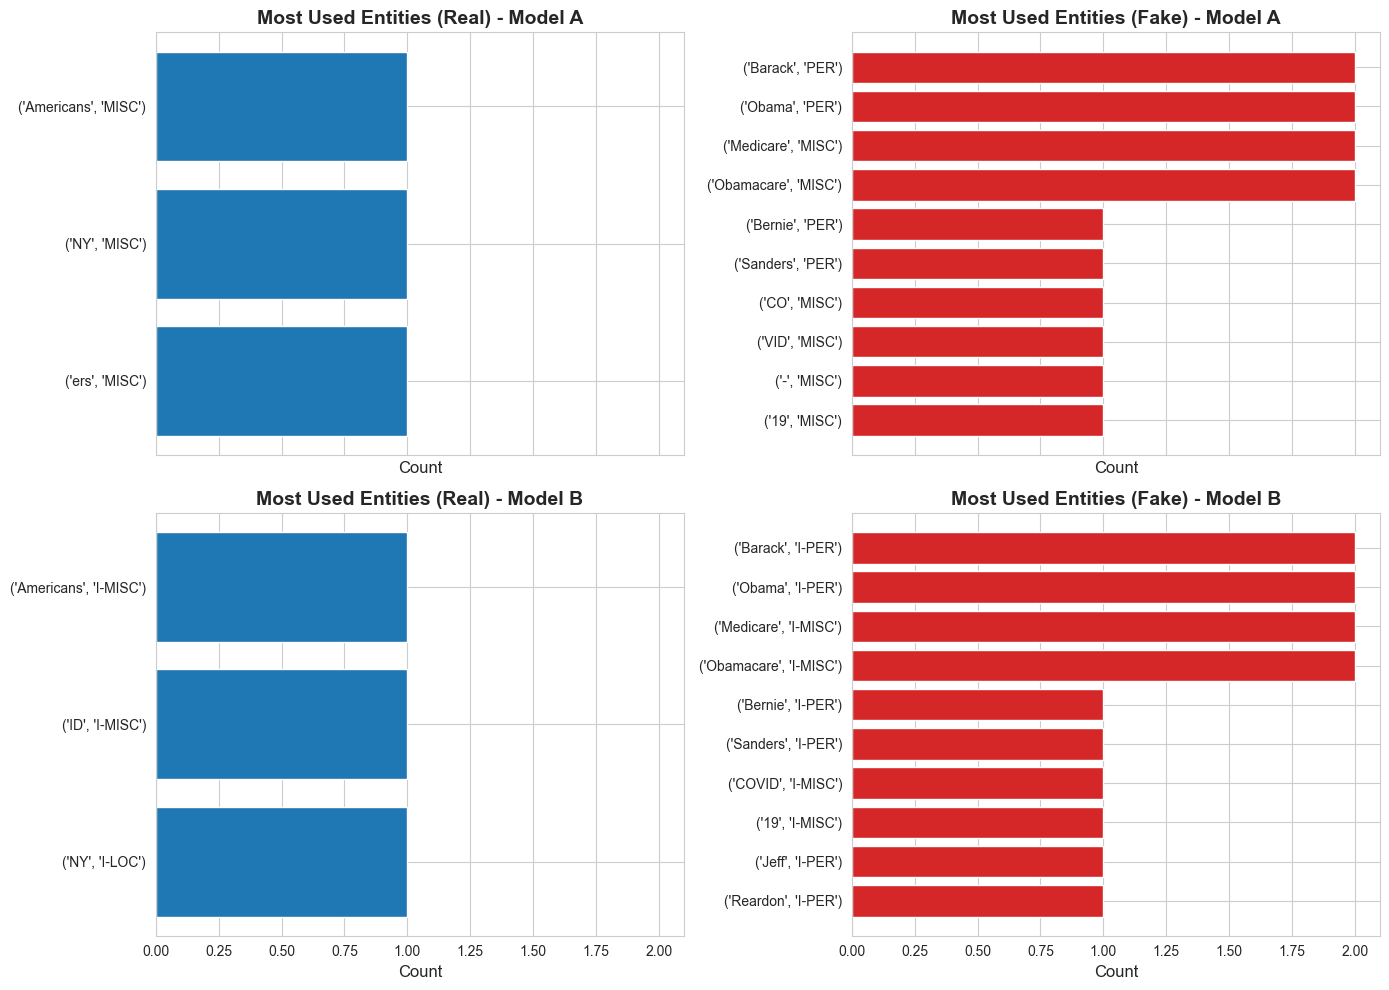

In [264]:
# 10: Visualization of model A,B Real vs Fake

# Sorting and selecting the top 10 entities from each category
df_counts_A_true["Entity"] = df_counts_A_true["Entity"].astype(str)
df_counts_A_false["Entity"] = df_counts_A_false["Entity"].astype(str)
df_counts_B_true["Entity"] = df_counts_B_true["Entity"].astype(str)
df_counts_B_false["Entity"] = df_counts_B_false["Entity"].astype(str)

true_counts_A = df_counts_A_true.sort_values(by="Count", ascending=False).head(10)
false_counts_A = df_counts_A_false.sort_values(by="Count", ascending=False).head(10)
true_counts_B = df_counts_B_true.sort_values(by="Count", ascending=False).head(10)
false_counts_B = df_counts_B_false.sort_values(by="Count", ascending=False).head(10)

# Set modern seaborn style
sns.set_style("whitegrid")
true_color = "#1f77b4"  # Blue for Real
false_color = "#d62728"  # Red for Fake

# Creating horizontal bar charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

# Plot Model A True entity counts
axes[0, 0].barh(true_counts_A["Entity"], true_counts_A["Count"], color=true_color)
axes[0, 0].set_title("Most Used Entities (Real) - Model A", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Count", fontsize=12)
axes[0, 0].invert_yaxis()

# Plot Model A False entity counts
axes[0, 1].barh(false_counts_A["Entity"], false_counts_A["Count"], color=false_color)
axes[0, 1].set_title("Most Used Entities (Fake) - Model A", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel("Count", fontsize=12)
axes[0, 1].invert_yaxis()

# Plot Model B True entity counts
axes[1, 0].barh(true_counts_B["Entity"], true_counts_B["Count"], color=true_color)
axes[1, 0].set_title("Most Used Entities (Real) - Model B", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Count", fontsize=12)
axes[1, 0].invert_yaxis()

# Plot Model B False entity counts
axes[1, 1].barh(false_counts_B["Entity"], false_counts_B["Count"], color=false_color)
axes[1, 1].set_title("Most Used Entities (Fake) - Model B", fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel("Count", fontsize=12)
axes[1, 1].invert_yaxis()

# Improve layout
plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()